## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
include("../src/GeneralizedPhaseModel.jl");
using PyCall

In [2]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 12
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

sys:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


### Model definition

In [3]:
dxdt(X, I, λ=5.0) = λ*(X[1]-I) - exp(I)*X[2]-λ*((X[1]-I)^2+X[2]^2)*(X[1]-I)
dydt(X, I, λ=5.0) = exp(I)*(X[1]-I) + λ*X[2]-λ*((X[1]-I)^2+X[2]^2)*X[2]
F(X, I) = [dxdt(X, I), dydt(X, I)]

D, N = 2, 2 # number of dimensions, units
Nθ = 1000
G(X, K) = K * ((1 .- eye(N)) * X[:, 1])
dt = 1e-3; T = 20; Nt = round(Int, T/dt)
trange = range(0, T, length=Nt)
alg = Tsit5();

In [4]:
@time Ts, ω, Xs = FindStablePeriodicSolution(F, 0, D, Nθ, [1, 0], dt, alg, 2, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

  5.826229 seconds (22.70 M allocations: 1.724 GiB, 6.00% gc time, 48.29% compilation time)
Ts=6.284 (sec) , ω=0.9998703544206853 (Hz)


In [5]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = ComputeGeneralizedPhaseSensitivityFunction(F, -1.2, 1.2, 0.1, D, Nθ, nothing, dt, alg, 2, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:00:10


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [6]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

### Run simulation

In [7]:
function all_simulation(N, D, ωI, ζθI, ξθI, XsI, coupled_func!, G, K, κ, initθ, alg=Tsit5(), NΘ=50, input_mode="I")
    @assert (input_mode == "I" || input_mode == "PQ") "input_mode must be `I` or `PQ`."
    
    g(X) = G(X, K)
    Xos, Θgos, Θcos = coupled_original_system(N, D, Nt, dt, XsI, g, coupled_func!, initθ, κ, alg)
    Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, Nt, dt, XsI, g, ωI, ζθI, Θcos[1, :], κ, alg)
    if input_mode == "I"
        IΘ = ComputeIsΘ(g, N, D, XsI, NΘ)
        Xgpm, Θgpm = coupled_generalized_phase_model_I(N, D, Nt, dt, XsI, IΘ, ωI, ξθI, Θgos[1, :], κ, alg)
        return Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm, IΘ
    elseif input_mode == "PQ"
        QΘ = ComputeQΘ(g, N, D, XsI, κ, ωI, NΘ)
        Xgpm, Θgpm = coupled_generalized_phase_model_PQ(N, D, Nt, dt, XsI, QΘ, ωI, ζθI, ξθI, Θgos[1, :], κ, g, alg)
        return Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm, QΘ
    end
end

all_simulation (generic function with 4 methods)

In [8]:
K = 0.5
κ = [1.0, 1.5]
initθ = [0, π]
NΘ = 50
input_mode = "I" # "I" or "PQ"

@time Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm, IΘ = all_simulation(
    N, D, ωI, ζθI, ξθI, XsI, coupled_func!, G, K, κ, initθ, alg, NΘ, input_mode);

Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00


 12.918816 seconds (48.60 M allocations: 3.024 GiB, 3.99% gc time, 91.92% compilation time)


### Results

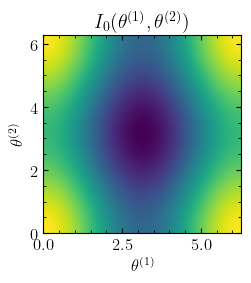

In [9]:
Θrange = range(0, 2π, length=100)
figure(figsize=(3,3))
title(L"$I_0(\theta^{(1)}, \theta^{(2)})$")
imshow(IΘ[1](Θrange, Θrange), extent=[0, 2pi, 0, 2pi])
xlabel(L"$\theta^{(1)}$"); ylabel(L"$\theta^{(2)}$");
tight_layout()

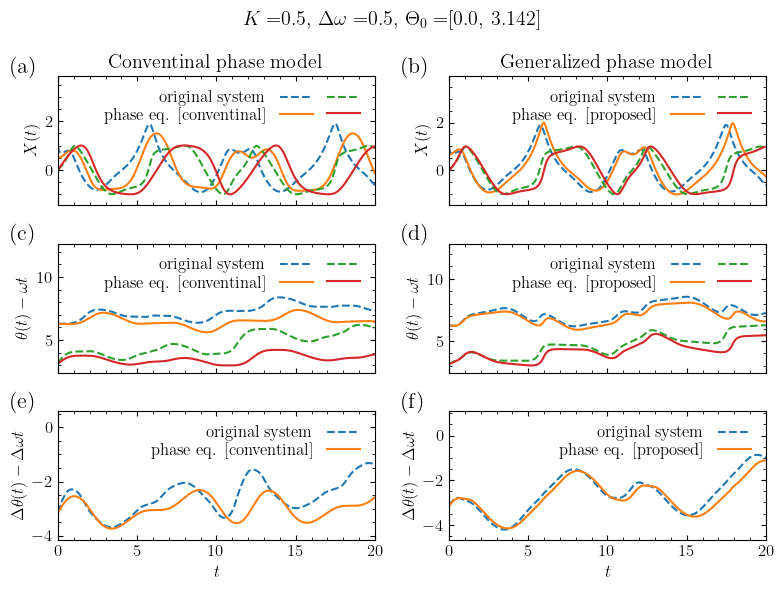

In [10]:
ωt1 = (κ[1]*ω) .* trange
ωt2 = (κ[2]*ω) .* trange;
Δωt = ωt2 - ωt1;

figure(figsize=(8, 6))
suptitle(L"$K=$"*string(K)*L", $\Delta \omega=$"*string(round((κ[2]-κ[1])*ω, digits=3))*L", $\Theta_0=$"*string(round.(initθ, digits=3)))
ax1 = subplot(3,2,1)
title("Conventinal phase model")
plot(trange, Xos[:, 1, 1], "--", label="original system")
plot(trange, Xcpm[:, 1, 1], label="phase eq. [conventinal]")
plot(trange, Xos[:, 1, 2], "--", label=" ")
plot(trange, Xcpm[:, 1, 2], label=" ")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.8); ylabel(L"$X(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax1.text(-0.15, 1.15, "(a)", fontsize=16, transform=ax1.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax2 = subplot(3,2,2)
title("Generalized phase model")
plot(trange, Xos[:, 1, 1], "--", label="original system")
plot(trange, Xgpm[:, 1, 1], label="phase eq. [proposed]")
plot(trange, Xos[:, 1, 2], "--", label=" ")
plot(trange, Xgpm[:, 1, 2], label=" ")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.8);  ylabel(L"$X(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax2.text(-0.15, 1.15, "(b)", fontsize=16, transform=ax2.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)


ax3 = subplot(3,2,3)
plot(trange, Θcos[:, 1]-ωt1, "--", label="original system")
plot(trange, Θcpm[:, 1]-ωt1, label="phase eq. [conventinal]")
plot(trange, Θcos[:, 2]-ωt2, "--", label=" ") 
plot(trange, Θcpm[:, 2]-ωt2, label=" ")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+4); ylabel(L"$\theta(t)-\omega t$"); 
plt.gca().axes.xaxis.set_ticklabels([])
#yticks([-pi, 0, pi, 2pi], [L"$-\pi$", "0", L"$\pi$", L"$2\pi$"]);
ax3.text(-0.15, 1.15, "(c)", fontsize=16, transform=ax3.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax4 = subplot(3,2,4)
plot(trange, Θgos[:, 1]-ωt1, "--", label="original system")
plot(trange, Θgpm[:, 1]-ωt1, label="phase eq. [proposed]")
plot(trange, Θgos[:, 2]-ωt2, "--", label=" ") 
plot(trange, Θgpm[:, 2]-ωt2, label=" ")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+4); ylabel(L"$\theta(t)-\omega t$"); 
plt.gca().axes.xaxis.set_ticklabels([])
#yticks([-pi, 0, pi, 2pi], [L"$-\pi$", "0", L"$\pi$", L"$2\pi$"]);
ax4.text(-0.15, 1.15, "(d)", fontsize=16, transform=ax4.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax5 = subplot(3,2,5)
plot(trange, Θcos[:, 2]-Θcos[:, 1]-Δωt, "--", label="original system")
plot(trange, Θcpm[:, 2]-Θcpm[:, 1]-Δωt, label="phase eq. [conventinal]")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.8); ylabel(L"$\Delta \theta(t)-\Delta \omega t$"); xlabel(L"$t$");
#yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
ax5.text(-0.15, 1.15, "(e)", fontsize=16, transform=ax5.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax6 = subplot(3,2,6)
plot(trange, Θgos[:, 2]-Θgos[:, 1]-Δωt, "--", label="original system")
plot(trange, Θgpm[:, 2]-Θgpm[:, 1]-Δωt, label="phase eq. [proposed]")
xlim(trange[1], trange[end]); ylim(ylim()[1]-0.3, ylim()[2]+1.8); ylabel(L"$\Delta \theta(t)-\Delta \omega t$"); xlabel(L"$t$");
#yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
ax6.text(-0.15, 1.15, "(f)", fontsize=16, transform=ax6.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

tight_layout()